In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
df = pd.read_excel("/Users/nick/Desktop/Data Analytics Projects/Cohort Analysis/Online Retail.xlsx")

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


From this, we see that 'Description' and 'CustomerID' have null values.

In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
df.duplicated().sum()

5268

5268 rows are duplicates.

In [12]:
df.drop_duplicates()
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


'Quantity' and 'UnitPrice' both have negative minimum values which don't make logical sense. We will control for this potential issue below.

In [16]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

This is not a perfect fix but it will control for observations that are clearly incorrect.

Below we will create the columns needed for the cohort analysis.

In [21]:
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
grouping = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = grouping.transform('min')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01


In [28]:
def get_month_int (dframe, column):
    year = dframe[column].dt.year
    month = dframe[column].dt.month
    day = dframe[column].dt.day
    return year, month, day

invoice_year, invoice_month, _ = get_month_int(df, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_month_int(df, 'CohortMonth')

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

df['CohortIndex'] = year_diff * 12 + month_diff + 1

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0


Below we will count the monthly active customers from each cohort.

In [31]:
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index = 'CohortMonth', columns = 'CohortIndex', values = 'CustomerID')
cohort_counts

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
cohort_size = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_size, axis = 0)
retention.round(3) * 100

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.6,32.3,38.4,36.3,39.8,36.3,34.9,35.4,39.5,37.4,50.3,26.6
2011-01-01,100.0,22.1,26.6,23.0,32.1,28.8,24.7,24.2,30.0,32.6,36.5,11.8,NaN
2011-02-01,100.0,18.7,18.7,28.4,27.1,24.7,25.3,27.9,24.7,30.5,6.8,NaN,NaN
2011-03-01,100.0,15.0,25.2,19.9,22.3,16.8,26.8,23.0,27.9,8.6,NaN,NaN,NaN
2011-04-01,100.0,21.3,20.3,21.0,19.7,22.7,21.7,26.0,7.3,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.0,17.3,17.3,20.8,23.2,26.4,9.5,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.4,15.7,26.4,23.1,33.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.1,20.7,22.3,27.1,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.7,24.9,24.3,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The heat map of the retention table will be displayed below.

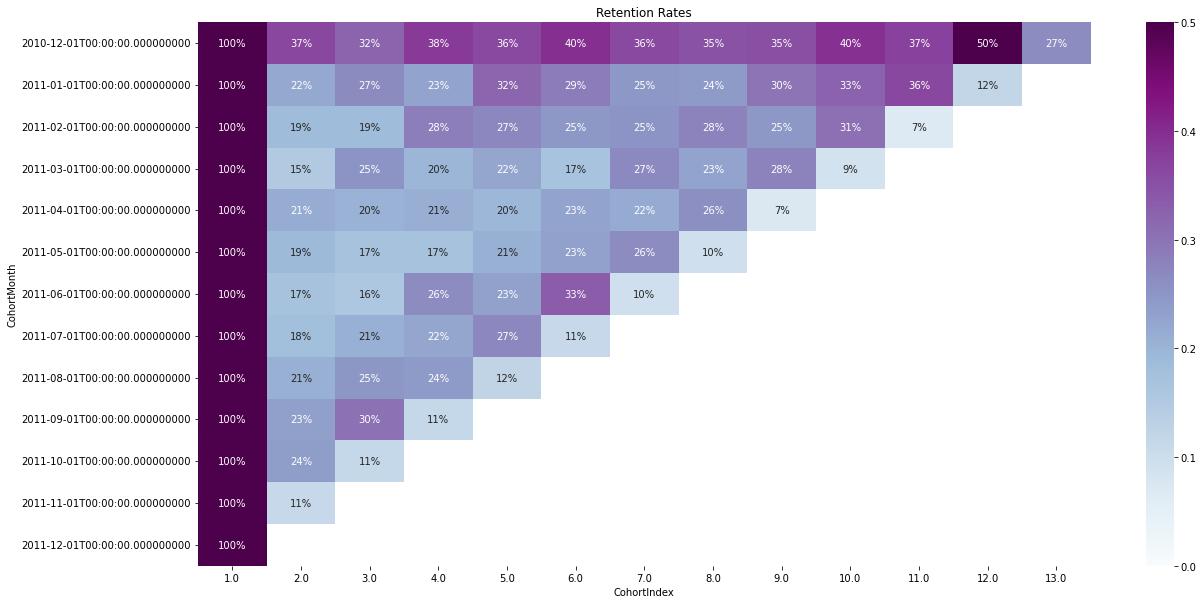

In [47]:
plt.figure(figsize = (20, 10))
plt.title('Retention Rates')
sns.heatmap(data = retention, annot = True, fmt = '.0%', vmin = 0.0, vmax = 0.5, cmap = 'BuPu')
plt.show()

Notes:
- The column containing cohort 1 will always be '100%' as it represents the total size of each cohort month.
- We can interpret this as follows:
    - December, 2010, cohort 3 (32%) means that 32% of the original cohort size made purchases in February, 2011
    
This interpretation holds true for the remaining retention rates.

Below we will determine the average quantity that each cohort purchased.

In [42]:
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()
avg_quantity = cohort_data.pivot(index = 'CohortMonth', columns = 'CohortIndex', values = 'Quantity')
avg_quantity.round(1)
avg_quantity.index = avg_quantity.index.date
avg_quantity

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
2010-12-01,11.938105,15.573125,15.593027,15.760628,13.505140,14.815346,15.963274,15.504725,18.087810,17.575223,18.872942,13.387148,15.250758
2011-01-01,17.248347,13.321171,12.617637,15.145635,12.784335,15.272587,14.891156,14.846875,11.573576,10.512856,9.422452,9.956236,NaN
2011-02-01,11.107391,13.536119,19.025853,11.988019,12.280948,12.264561,13.539591,13.329562,10.852063,12.315682,13.390244,NaN,NaN
2011-03-01,9.903989,11.681596,13.266002,10.089765,14.292843,12.954137,13.399392,13.742945,11.169345,9.473896,NaN,NaN,NaN
2011-04-01,9.991433,10.390747,9.768454,11.846272,11.797654,8.588322,9.898109,9.479414,7.449331,NaN,NaN,NaN,NaN
2011-05-01,11.340957,9.625688,14.086245,12.757906,11.141816,8.686333,10.637374,109.930468,NaN,NaN,NaN,NaN,NaN
2011-06-01,10.579657,14.528139,10.819328,13.549084,10.560726,9.815911,9.411483,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,9.837340,13.750499,7.307577,8.086257,6.120728,7.064639,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,10.031295,6.173750,5.413478,6.153709,7.056730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-01,12.061121,6.229123,8.004535,8.923875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Below we will plot the heatmap of the avg_quantity pivot table.

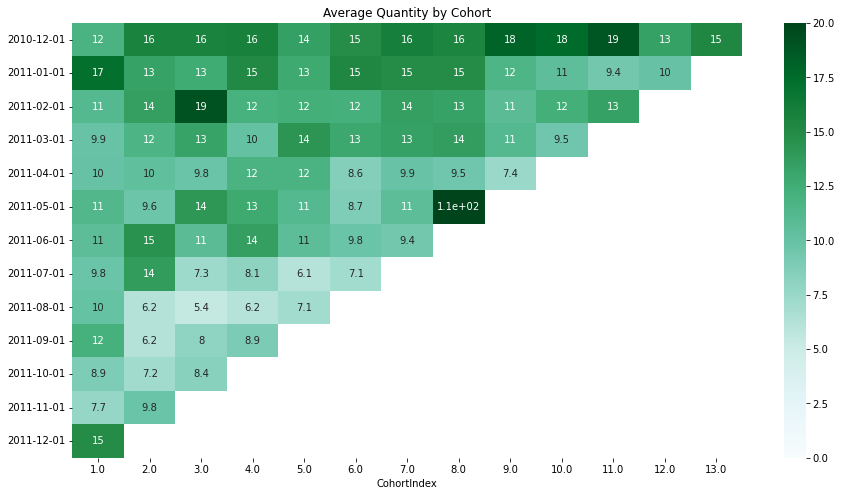

In [48]:
plt.figure(figsize=(15,8))
plt.title('Average Quantity by Cohort')
sns.heatmap(data = avg_quantity, annot = True, vmin = 0, vmax = 20, cmap = 'BuGn')
plt.show()

Notes:
- The main takeaway from this heatmap is that even as the amount of people in the cohort drops over time, the quantity purchased in each cohort doesn't seem to be effected proportionately.